# State Space Model (Parameter Estimation)

## Binomial Distribution(二項分布)

Before explaining state space model, we briefly check **Binomial Distribution**, which is also important distribution
.

Binomial distribution is **discrete** probability distribution of the number of successes in a sequence of n independent experiments, each asking a yes–no question(ex. succeed or not, True or False, 0 or 1, etc...)

Example: the number of head side in 10 coin-toss, the number of win in 5 scissors-paper-rock game

Binomial distribution has 2 parameters: **N: Number of trial** (ex. number of coin-toss) and **p: probability of success**(ex. probability of head side)

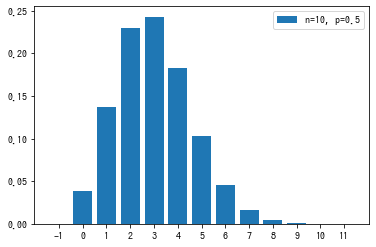

In [5]:
# number of head side in 10 coin toss
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import binom # module for binomial distribution
import numpy as np

x = np.linspace(-1, 11, 13) # -1, 0 , 1, 2, ..., 11
plt.bar(x, binom.pmf(x, p = 0.15, n = 20), label="n=10, p=0.5") 
# n: number of trial (in this case, number of coin toss)
# p: probability of event (in this case, probability of head side)
plt.xticks(x)
plt.legend();

**Feature of binomial distribution**:  
- binomial distribution is **discrete** distribution
- takes probability only with integer 0 ~ n (0,1,2,..., n). Otherwise, probability is 0.

In [2]:
np.sqrt(10 * 0.5 * (1 - 0.5))

1.5811388300841898

If p = 0.5, binomial distribution is symmetrical, but otherwise, binomial distribution is asymmetrical.  
Average is $np$. For example, if $n = 10, p = 0.5$, average is 5 (= 10 * 0.5). 
Standard deviation(SD) is $\sqrt{np(1-p)}$. For example, if $n = 10, p = 0.5$, SD is 1.58.. (= $\sqrt{10 \cdot 0.5 \cdot (1 - 0.5)}$). 

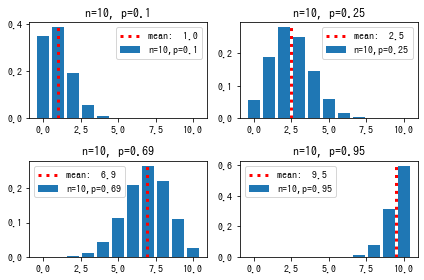

In [3]:
x = np.linspace(0, 10, 11)
fig = plt.figure()
for i, p in enumerate([0.1, 0.25, 0.69, 0.95]):
    ax = fig.add_subplot(2, 2, i+1)
    ax.bar(x, binom.pmf(x, p=p, n=10), label=f"n=10,p={p}") # n: trials, p: probability of event
    ax.vlines(x=10*p, ymin=0, ymax=binom.pmf(x, p=p, n=10).max(), 
              linestyle=":", linewidth=3, color="red", label=f"mean: {10*p: .1f}") # red line
    ax.set_title(f"n=10, p={p}")
    ax.legend()
plt.tight_layout()

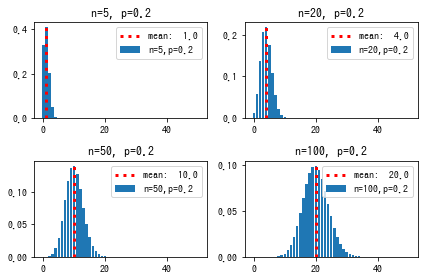

In [4]:
x = np.linspace(0, 50, 51)
fig = plt.figure()
p = 0.2
for i, n in enumerate([5, 20, 50, 100]):
    ax = fig.add_subplot(2, 2, i+1)
    ax.bar(x, binom.pmf(x, p = p, n = n), label=f"n={n},p={p}") # n: trials, p: probability of event
    ax.vlines(x=n*p, ymin=0, ymax=binom.pmf(x, p = p, n = n).max(), 
              linestyle=":", linewidth=3, color="red", label=f"mean: {n * p: .1f}") # red line
    ax.set_title(f"n={n}, p={p}")
    ax.legend()
plt.tight_layout()

If n is large and p is not so small or big, Binomial distribution can be approximated to **Normal distribution**.  
$$N\left(np, \sqrt{np(1-p)}\right)$$

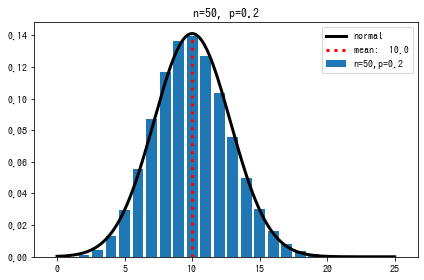

In [28]:
from scipy.stats import norm # normal distribution
n = 50; p = 0.2
x = np.linspace(0, 25, 26)
plt.bar(x, binom.pmf(x, p=p, n=n), label=f"n={n},p={p}") # n: trial, p: probability of event
plt.vlines(n*p, 0, binom.pmf(x, p=p, n=n).max(), 
          linestyle = ":", linewidth=3, color="red", label=f"mean: {n*p: .1f}") # red line
plt.title(f"n={n}, p={p}")

x2 = np.linspace(0, 25, 251) # x for normal distribution
plt.plot(x2, norm.pdf(x2, loc=n*p, scale=np.sqrt(n*p*(1-p))), color="black", linewidth=3,
        label="normal") # approximation with normal distribution
plt.legend()
plt.tight_layout()

If n is large and p is small, Binomial distribution can be approximated to **Poisson distribution**.  
$$Poisson\left(np\right)$$

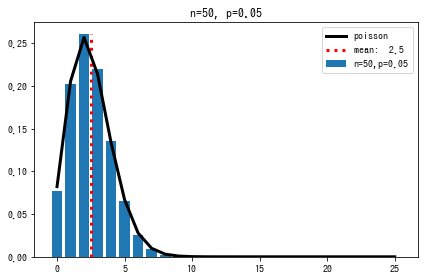

In [29]:
from scipy.stats import poisson # poisson distribution

n = 50; p = 0.05
x = np.linspace(0, 25, 26)
plt.bar(x, binom.pmf(x, p=p, n=n), label=f"n={n},p={p}") # n: trial, p: probability of event
plt.vlines(n*p, 0, binom.pmf(x, p=p, n=n).max(), 
          linestyle = ":", linewidth=3, color="red", label=f"mean: {n*p: .1f}") # red line
plt.title(f"n={n}, p={p}")

plt.plot(x, poisson.pmf(x, mu=n*p), color="black", linewidth=3,
        label="poisson") # approximation with poisson distribution
plt.legend()
plt.tight_layout()

## パラメータ推定法概観

パラメータ推定方法は、大別すると以下の2種類に分けることができる。(強化学習は除く)
- 最尤推定
    - EMアルゴリズムも最尤推定の1種である
    - 最小二乗法も考え方は最尤推定に近い
        - ディープラーニングも最小二乗法
- ベイズ推定
    - カルマンフィルタはベイズ推定と最尤推定を組み合わせて使う
    - MCMCや粒子フィルタはベイズ推定のみ
    - 最近話題のガウス過程もベイズ推定のみ

## Maximum Likelihood Estimation(最尤推定)

先週のスキトラで言及したように、尤度は「モデルのあてはまりの良さ」の指標として用いることができる。  
手元にあるデータに対して、尤度が最も大きくなるようなパラメータ(=最も手元のデータに対してあてはまりの良いパラメータ)を求め、推定値とする方法を**最尤推定**という。

例)あなたはギャンブルに参加しようとしています。そのギャンブルではコインを使うのですが、コインは相手方が用意したコインなので、イカサマがあるかもしれません。  
あなたはコインを10回投げて、確かめてみることにしました。すると、表が6回、裏が4回出ました。
このときのデータから、最尤推定を用いてコインの表が出る確率$p$を推定してみて下さい。

最尤推定では、先述の通り、尤度が最大となるようなパラメータ(今回であれば表の出る確率$p$)を求める。

コインの表の出る回数を、$n=10, p=\theta$の二項分布でモデルする。  
この$\theta$が今回の推定したいパラメータである。$\theta=0.5$もしくはその近辺であれば、コインにはイカサマはないと言えるだろう。

例えば$\theta=0.2$であれば(圧倒的に裏が出やすいということになる)、尤度は以下のように計算できる

In [30]:
# likelihood
theta = 0.2
binom.pmf(6, n = 10, p = theta) # 表が6回、 n(試行回数)は10回、pはtheta

0.00550502400000001

尤度は0.0055となる

In [31]:
theta = 0.6
binom.pmf(6, n = 10, p = theta) # 表が6回、 n(試行回数)は10回、pはtheta

0.2508226560000002

In [8]:
# thetaを変えて、尤度をいくつか見てみましょう。どのthetaだと、尤度が一番大きいでしょうか？


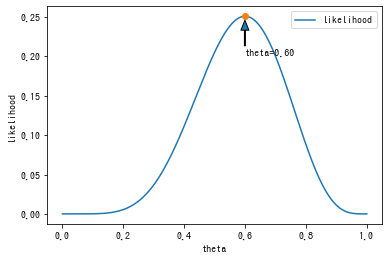

In [22]:
x = np.linspace(0, 1, 1000)
likelihood = binom.pmf(6, n=10, p=x)
max_likelihood_idx = np.argmax(likelihood)
max_likelihood_theta = x[max_likelihood_idx]
max_likelihood = likelihood[max_likelihood_idx]
plt.plot(x, likelihood,label="likelihood")
plt.plot(max_likelihood_theta, max_likelihood, "o")
plt.annotate(f"theta={max_likelihood_theta:.2f}", 
             xy=(max_likelihood_theta,max_likelihood*0.98),
             xytext=(max_likelihood_theta, max_likelihood*0.8),
             arrowprops=dict(shrink=0, width=1, headwidth=8, 
                                headlength=10, connectionstyle='arc3'))
plt.xlabel("theta")
plt.ylabel("likelihood")
plt.legend();

$\theta=0.6$のときに尤度は最大となるので、コインの表の出る確率$p$の推定値は**0.6**となる。  

scipyには最適化を行う便利な関数があるので、これを使う。実はstatsmodelsの裏側では、最尤推定をする際に、このscipy.optimizeが使用されている。

In [23]:
from scipy.optimize import minimize # 残念ながらmaximizeはないので、minimizeを使う
from scipy.stats import binom # 二項分布

# 最小化したい関数。対数尤度を最大化したいので、-1 * 対数尤度を最小化する。
def neg_loglike(theta):
    return -binom.pmf(6, n=10, p=theta)

initial_value = [0.1] # 適当な初期値。0~1の間であれば何でもよい。

# 引数は最小化したい関数、探索したいパラメータ、最適化アルゴリズム
result = minimize(neg_loglike, initial_value, method='Nelder-Mead') 

In [24]:
result.x # 負の対数尤度を最小にする(対数尤度を最大にする)パラメータ

array([0.6])

In [12]:
result.fun # 最小となった負の対数尤度

-0.2508226560000003

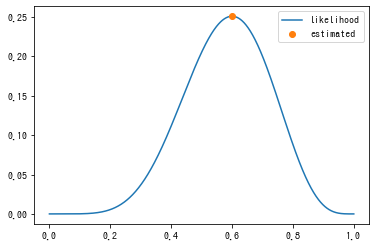

In [13]:
# グラフ: 再掲
x = np.linspace(0, 1, 1000)
likelihood = binom.pmf(6, n=10, p=x) # likelihood
plt.plot(x, likelihood, label="likelihood")
plt.plot(result.x[0], -result.fun, "o", label="estimated")
plt.legend();

正しい推定値を得ることができた。

実は上記の例は、数式から最大尤度とそのときのパラメータを計算することもできる。(notebookの末尾を参照)。しかし、モデルが複雑になってくると数式で求めることは次第に難しくなってくる。

### 最尤推定で状態空間モデルのパラメータ推定

では先週の状態空間モデルの各パラメータを、全て最尤推定で求めてみる。  
- <font color=red>**注意**</font>: 状態空間モデルのパラメータは一般に、後述のベイズ推定や、ベイズ推定と最尤推定の組み合わせで推定することが多い。パラメータの数が多いので、最尤推定を使うと、計算に時間がかかる上、変な値にオーバーフィット(過学習)する危険性が高いためである。
    - ベイズ推定と最尤推定の組み合わせるときは、パラメータ数が多い"状態"(今回の例では本当の川の高さ)はベイズ推定で求め、固定されたパラメータ(今回の例では川の変動の標準偏差やAさんの計測誤差)を最尤推定で求める。この方法であれば、最尤推定で求めるパラメータ数は少ないので、オーバーフィットしにくく、計算時間も現実的である。

In [25]:
# Aさんが観測した水面の高さ。全部で11年分
data = [10.06097469, 10.40798098, 10.52350358, 10.3303128 , 11.45294242,
       11.63782415, 11.3387652 , 12.84233771, 13.0128606 , 12.53294464,
       13.77612241]

In [66]:
neg_loglike_local_level([ 9.52402481, 10.27834895, 10.27340228, 10.26140531, 11.30307823,
       11.56218191, 11.1107155 , 12.7805329 , 12.76147655, 12.49654322,
       13.4533628 ,  0.68482283,  0.22276665])

11.368770130361142

In [26]:
# 最小化したい関数。対数尤度を最大化したいので、-1 * 対数尤度を最小化する。
def neg_loglike_local_level(params):
    states = params[:11] # パラメータの11番目までが、本当の水面の高さ
    sigma_v = params[11] # パラメータの12番目は、本当の水面の高さの毎年の変動の標準偏差
    sigma_w = params[12] # パラメータの13番目は、Aさんの水面の測定誤差

    likelihoods_s = np.zeros(11)
    likelihoods_y = np.zeros(11)
    # s_{t} ~ N(s_{t-1}, sigma_v)の対数尤度
    for i in range(1, 11):
        likelihoods_s[i] = np.log(norm.pdf(states[i], loc=states[i-1], scale=sigma_v))
    
    # y_{t} ~ N(s_{t}, sigma_v)の対数尤度
    for i in range(11):
        likelihoods_y[i] = np.log(norm.pdf(data[i], loc=states[i], scale=sigma_w))
        
    loglike = sum(likelihoods_s + likelihoods_y)
    return -loglike

In [58]:
# 適当な初期値。今回は本当の高さは全て10、川の変動の標準偏差と測定誤差も10で。
initial_value = np.array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=np.float)
result_ss = minimize(neg_loglike_local_level, initial_value, method='Nelder-Mead')

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


In [65]:
result_ss.x

array([ 9.52402481, 10.27834895, 10.27340228, 10.26140531, 11.30307823,
       11.56218191, 11.1107155 , 12.7805329 , 12.76147655, 12.49654322,
       13.4533628 ,  0.68482283,  0.22276665])

In [44]:
result_ss.x[:11] # 本当の水面の高さの推定値

array([ 9.56672299, 13.19909316, 11.92415422,  7.05065237, 11.17000772,
       12.37789046,  8.99753816, 11.3535219 ,  8.8522228 , 14.24563453,
       14.39038792])

In [45]:
result_ss.x[11] # 水面の変動の標準偏差

3.386811989909628

In [46]:
result_ss.x[12] # 測定誤差

2.1348161437277504

In [47]:
len(data)

11

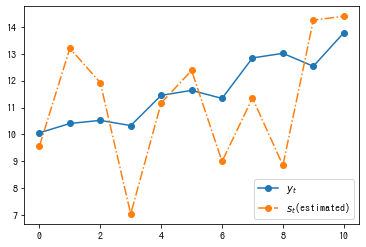

In [48]:
plt.plot(data, "o-", label="$y_{t}$")
plt.plot(result_ss.x[:11], "o-.", label="$s_{t}$(estimated)")
plt.legend()

In [22]:
# 初期値を変えて、何度か実行してみましょう。結果は変わるでしょうか？

#### ローカルミニマムと最適化

推定結果が変わってしまう原因としては、先程のscipy.minimizeは、"全ての取りうるパラメータの値"を調べているわけではなく、所定のアルゴリズムに沿って、一部のパラメータの値しか調べていないことが挙げられます。

なぜ全部のパラメータではなく、一部のパラメータしか調べないのかというと、変数が増えるにつれて、組み合わせの数が膨大になるからです。

In [49]:
# 例 1変数につき、1000個の点を調べる場合
# パラメータが3つの場合の調べるべき組み合わせの数
1000 ** 3

1000000000

In [50]:
# パラメータが10つの場合の調べるべき組み合わせの数
1000 ** 10

1000000000000000000000000000000

なので、一部のパラメータをなるべく効率的に調べるアルゴリズムが色々と開発されてきました。  
しかしながら、それらにほぼ共通する欠点は、"ローカルミニマム"にハマってしまうことです。

例えば、以下のような関数があったとして、最小値を求めてみます

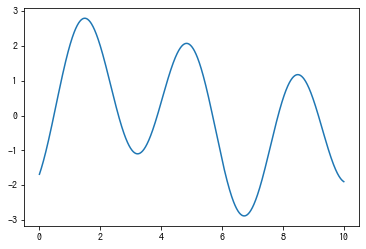

In [52]:
x = np.linspace(0,10,1000)
def fx(x):
    return np.sin(2 * np.pi/10 * x) + 2 * np.sin(2 * np.pi/3.5 * x - 1)

plt.plot(x, fx(x))

In [53]:
result = minimize(fx, [2], method='Nelder-Mead') # 初期値: 2

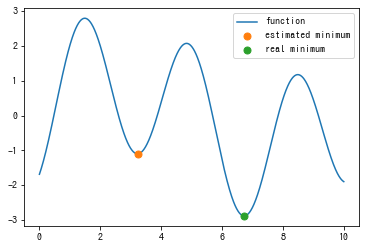

In [54]:
# 結果をプロット
plt.plot(x, fx(x), label="function")
plt.plot(result.x[0], result.fun, "o", markersize=7, label="estimated minimum")
min_index = np.argmin(fx(x))
plt.plot(x[min_index], fx(x)[min_index], "o", markersize=7, label="real minimum")
plt.legend()

本来は7近辺が最小値だが、3近辺の谷間にハマってしまいました。このような局所的な最小値(極小値)を、機械学習では**"ローカルミニマム"**と呼ぶことがあります。(局所解ということもあります。)

このような場合のシンプルな対策は、初期値を変えて、もう一度試してみることです。

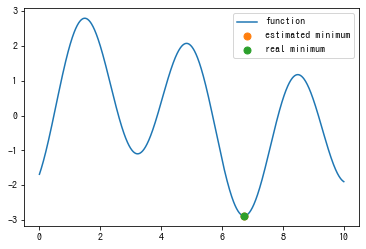

In [55]:
result = minimize(fx, [8], method='Nelder-Mead') # 初期値: 8
# 結果をプロット
plt.plot(x, fx(x), label="function")
plt.plot(result.x[0], result.fun, "o", markersize=7, label="estimated minimum")
min_index = np.argmin(fx(x))
plt.plot(x[min_index], fx(x)[min_index], "o", markersize=7, label="real minimum")
plt.legend()

(点が重なってしまっていますが、)今回は上手くいきました。

実はこのローカルミニマムの問題は至るところにあり、ディープラーニングのここ最近の発展の歴史も、一部はこのローカルミニマムとの闘いに費やされています。  
ローカルミニマムに対する対策案としては、
- よい初期値を選ぶ(上の例でいえば、初期値8を選ぶ)。または、良さそうな候補を選び、複数試す。
- そもそも余計な谷間のないような目的関数をつくる。(最大/最小化したい関数を"目的関数"と呼ぶことがあります。)
    - 最尤推定では、負の対数尤度が目的関数です
    - ちなみにディープラーニングをはじめ、教師あり学習では、予測結果と教師データの誤差が目的関数としてよく用いられます。
- 全く違うアプローチを試す

などがありますが、次にご紹介するベイズ推定は、3番目の"全く違うアプローチ"といえます。

#### 推定の評価

実は上記のデータは、以下の本当の川の高さと、川の変動の標準偏差0.7m, Aさんの測定誤差0.3mでシミュレートしたデータでした。

In [56]:
s_real = [10.2       , 10.54769991, 10.4509149 , 10.90429687, 11.97041777,
       11.80651041, 11.64261454, 12.74806351, 13.28526782, 12.95663575,
       13.33642778]

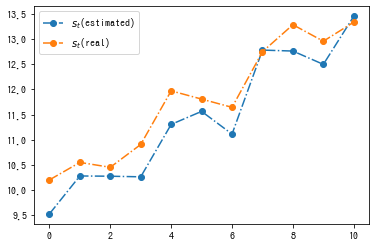

In [59]:
plt.plot(result_ss.x[:11], "o-.", label="$s_{t}$(estimated)")
plt.plot(s_real, "o-.", label="$s_{t}$(real)")

plt.legend()

当たらずしも遠からずです。

## ベイズ推定

### ベイズ推定とは

先程紹介した最尤推定は、ローカルミニマムにハマって変な推定値が出てしまう、データにオーバーフィット(過学習)しやすい、などの欠点があります。  
その対策として、**ベイズ推定(Bayes Estimation)**を紹介します。  
ベイズ推定は、最尤推定のようにパラメータの値をピンポイントで推定(**点推定**)するのではなく、パラメータの**分布を推定**するのが最大の特徴です。 

ベイズ推定では、以下の式(**ベイズの定理**)に従い、パラメータの分布のアップデートを行い、パラメータ分布の推定値とします。  
ベイズ推定において、推定されたパラメータの分布を**事後分布**と呼びます。  
ベイズ推定では、何か適当にパラメータの分布を予め決めておいて(これを**事前分布**と呼びます)、それをベイズの定理を使ってアップデートして、最終的なパラメータの分布の推定値(事後分布)を得ます。

$$パラメータの事後分布 = p(\theta | Y) = \frac{P(Y | \theta)P(\theta)}{P(Y)} = 
\frac{P(Y | \theta)P(\theta)}{\sum_{\theta}\left\{ P(Y | \theta)P(\theta) \right\}} \\ = 
\frac{(尤度) \cdot (パラメータの事前分布における確率)}{\sum_{パラメータ}\left\{(尤度) \cdot (パラメータの事前分布における確率)\right\}}
$$

すなわち  
1.事前分布(適当に決めたパラメータの分布)を用意 → 2.尤度による更新 → 3.事後分布(求めたいパラメータの分布の推定値)を得る  
という流れです。

何が何やら分からないと思うので、実際にやってみます。

例) Aさんがコインを10回投げたところ、表が10回連続して出てきました。Aさんはこのコインはかなり怪しいかもと思っていますが、とはいえ表の出る確率は普通0.5近辺のはずです。ベイズ推定を使って、このコインの表のでる確率を推定してみます。

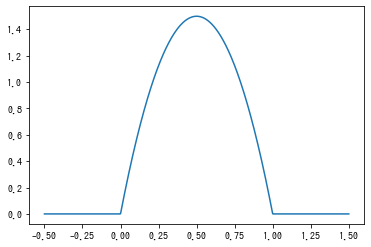

In [89]:
# まず、事前分布を用意します。流石に表の出る確率は0.5近辺のはずです。
# 表の出る確率が0~1の範囲を超えてしまうと困るので、0から1の範囲を取る、ベータ分布を使います
from scipy.stats import beta
x = np.linspace(-0.5,1.5,1000)
plt.plot(x, beta.pdf(x, 2, 2)) # ベータ分布は2つのパラメータを取ります。両方のパラメータの大きさが同じだと、左右対象となります。

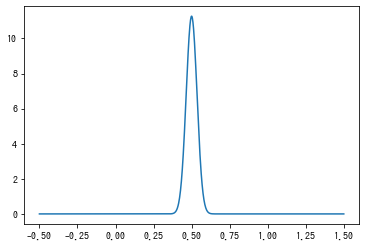

In [68]:
plt.plot(x, beta.pdf(x, 100, 100)) # パラメータの大きさが大きくなると、より細長い形になります

Aさんは"コインといえば表の出る確率は0.5近辺のはずだが、正直あんまり自信がない"ということで、コインの表の出る確率の事前分布として、下の形の分布を使うことにしました。

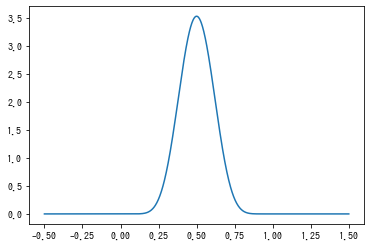

In [90]:
plt.plot(x, beta.pdf(x, 10, 10)) # 事前分布

In [91]:
beta.cdf(0.40, 10, 10) # 表の出る確率が0.40以下の確率は約19%

0.18609202141541173

In [92]:
beta.cdf(0.60, 10, 10) # 表の出る確率が0.60以下の確率は約81%

0.8139079785845883

次に、ベイズの定理を使って表の出る確率を更新します。
$$推定後の分布における、パラメータがaとなる確率 = \frac{パラメータがaのときのデータに対する尤度 \times 事前分布における、パラメータがaとなる確率}{分母}
$$

In [93]:
# 分子を計算
# 例)表が出る確率が0.45となる確率 (注: 表が出る確率がpのコインをn回投げたときの表の回数がkとなる尤度は、二項分布で計算できる)
# beta分布については確率の代わりに確率密度関数を使っているが、あとでまとめて分母で調整するので、問題ない
binom.pmf(k=10, n=10, p=0.45) * beta.pdf(0.45, 10, 10)
# 尤度 x 事前分布

0.0010961513489289492

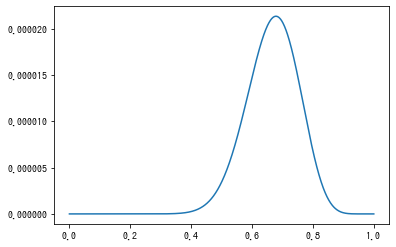

In [95]:
# 0から1までを1000個に分割し、分子を計算
x = np.linspace(0, 1, 1000) # 0, 0.001, ..., 1
numerator = binom.pmf(k=10, n=10, p=x) * beta.pdf(x, 10, 10) * 0.001 # 尤度 x 事前分布の確率
plt.plot(x, numerator)

In [98]:
estimated_probability_theta.sum()

1.0000000000000013

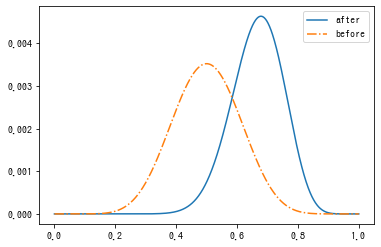

In [96]:
# 分母は、分子を足し合わせて分母とする。要するに、事後分布の和が1にさえなれば、なんでも良いのである。
denominator = sum(numerator)

# すると、ベイズの定理により、事後分布が計算できる
estimated_probability_theta = numerator / denominator
plt.plot(x, estimated_probability_theta, label="after")

prior_probability_theta = beta.pdf(x, 10, 10) * 0.001
plt.plot(x, prior_probability_theta, "-.", label="before")
plt.legend()

Aさんは、データを得る前(10回連続で表が出る前)までは、橙線がコインの表の出る確率の分布だと思っていましたが、10回連続で表が出てしまったので、それはベイズの定理により修正(更新)され、青線がコインの表の出る確率となっています。

このように、予め決めておいたパラメータの事前分布を、データによって修正し、パラメータの推定値とする方法が**ベイズ推定**です

最尤推定のように一点の推定値が欲しい場合は、推定後の分布(上の青線分布)の、
- 最頻値(ピーク)を推定値とする方法 = **MAP推定値**
- 平均値を推定値をする方法 = **EAP推定値**

などの方法があります。

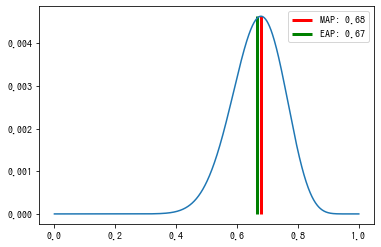

In [99]:
# MAP推定値
max_idx = np.argmax(estimated_probability_theta)
map_est = x[max_idx]

# EAP推定値
eap_est = np.dot(estimated_probability_theta,x)

plt.plot(x, estimated_probability_theta) # 分布

# 縦線: 引数は、xの位置、縦線の下端、縦線の上端、太さ、色、ラベル
# ラベル内は{~~:.2f}とすることで、小数点以下第2位まで表示している
plt.vlines(map_est, 0, estimated_probability_theta.max(), linewidth=3, color="red", label=f"MAP: {map_est:.2f}")
plt.vlines(eap_est, 0, estimated_probability_theta.max(), linewidth=3, color="green", label=f"EAP: {eap_est:.2f}")
plt.legend()

ベイズ推定の良いところの一つは、推定結果を用いた検定や評価が容易であることである。  
例えば、上の推定結果を元に、Aさんはこのコインがイカサマだとして賭博場を訴えることにした。このコインの表が出る確率が0.5以下である確率は、

In [100]:
import pandas as pd

s_probability = pd.Series(estimated_probability_theta, index=x)
s_probability.loc[:0.5].sum()

0.030713549812387792

わずか3%である。

### データによって変わるベイズ推定結果

ベイズ推定の良いところの一つは、データが来るたびに、その都度分布を更新することも可能な点である。  
これは、リアルタイムで予測をする際などに効果を発揮する。

上記と同じ例で、10回表が出たあとに分布を更新するのではなく、コインを投げる度に分布を更新してみる。

In [101]:
# 表の回数、コインを投げた回数、事前分布を入力すると、事後分布を返す関数
# 分布のフォーマットはindexがx、確率がvalueのpd.Series
def update_probability(num_head, num_trial, prior_prob):
    x = prior_prob.index
    numerator = binom.pmf(k=num_head, n=num_trial, p=x) * prior_prob.loc[x] # 分子
    denominator = sum(numerator) # 分母
    updated_prob = pd.Series(numerator/denominator, index=x)
    return updated_prob

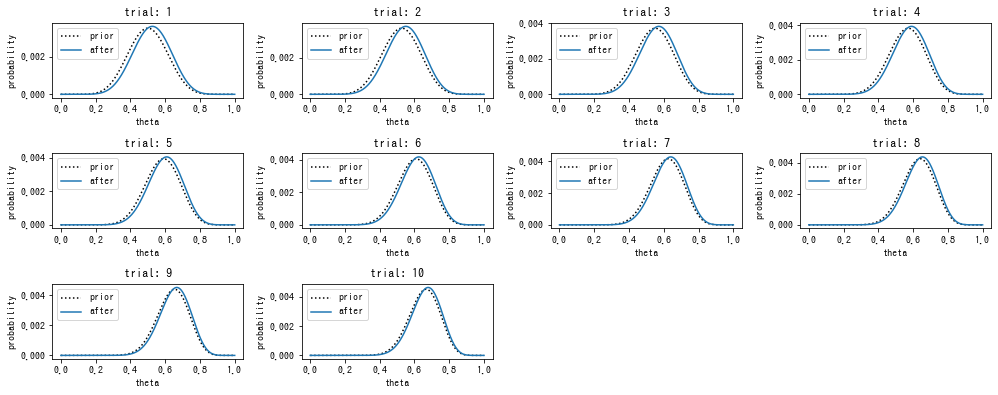

In [104]:
# 10回表を観測する
x = np.linspace(0, 1, 1000)
probability = pd.Series(beta.pdf(x, 10, 10) * 0.001, index=x)
initial_prob = probability
fig = plt.figure(figsize=(14,7))
for i in range(10): 
    ax = fig.add_subplot(4,4,i+1)
    ax.plot(probability, "k:", label="prior") # 当初のプロット

    # 更新
    probability = update_probability(1, 1, probability) # コインを1回なげたら、1回表がでた
    ax.plot(probability, label="after") # 更新後のプロット
    ax.set(title=f"trial: {i+1}", ylabel="probability", xlabel="theta")
    ax.legend(loc=2)
plt.tight_layout()

徐々にデータによって、分布が更新されている様子が分かる

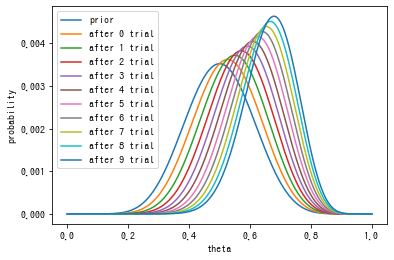

In [103]:
# 10回表を観測する
x = np.linspace(0, 1, 1000)
probability = pd.Series(beta.pdf(x, 10, 10) * 0.001, index=x)
plt.plot(probability, label="prior")
for i in range(10): 
    # 更新
    probability = update_probability(1, 1, probability) # コインを1回なげたら、1回表がでた
    plt.plot(probability, label=f"after {i} trial") # 更新後のプロット

plt.ylabel("probability")
plt.xlabel("theta")
plt.legend()

このように、事前分布がデータによって徐々に更新されるため、過学習がしにくいことが特徴である。  
(他方、ディープラーニングはデータ数が少ないと過学習しやすいことが課題の一つであり、通常、多くのデータを要するが、昨今ベイズ推定を用いたディープラーニングの学習方法が研究され、注目を浴びている。最新の研究分野である。)

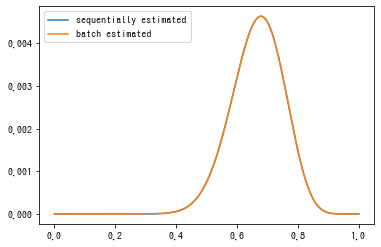

In [44]:
plt.plot(probability, label="sequentially estimated")
plt.plot(s_probability, label="batch estimated")
plt.legend()

一度に10回分のデータを使って更新しても、都度更新して10回分繰り返しても、結果は同じ。

### 事前分布によって変わるベイズ推定結果

ベイズ推定には難点もある。そのうちの一つが、事前分布によって、推定結果が変わってしまうことである。  
(これが理由で、未だにあまりベイズ推定をよく思っていない統計学者もいるらしい)  
(ちなみに、前半で解説した最尤推定を考案したR.A.フィッシャーは、ベイズ推定を断固として認めず、否定しまくり、当時のフィッシャーが学会の権威だったこともあり、ベイズ統計学は冬の時代を過ごしたという...)

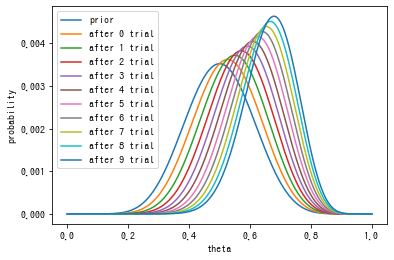

In [45]:
# 事前分布をbeta(x, 10, 10)として、表を10回観測した場合(再掲)
x = np.linspace(0, 1, 1000)
probability = pd.Series(beta.pdf(x, 10, 10) * 0.001, index=x)
plt.plot(probability, label="prior")
for i in range(10): 
    # 更新
    probability = update_probability(1, 1, probability) # コインを1回なげたら、1回表がでた
    plt.plot(probability, label=f"after {i} trial") # 更新後のプロット

plt.ylabel("probability")
plt.xlabel("theta")
plt.legend()

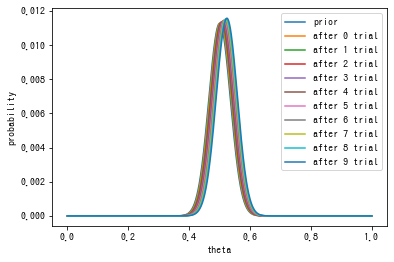

In [46]:
# 事前分布をbeta(x, 100, 100)として、表を10回観測した場合
x = np.linspace(0, 1, 1000)
probability = pd.Series(beta.pdf(x, 100, 100) * 0.001, index=x)
plt.plot(probability, label="prior")
for i in range(10): 
    # 更新
    probability = update_probability(1, 1, probability) # コインを1回なげたら、1回表がでた
    plt.plot(probability, label=f"after {i} trial") # 更新後のプロット

plt.ylabel("probability")
plt.xlabel("theta")
plt.legend()

後者は事前分布が0.5に集中しており(=強い自信をもって、コインの表の出る確率は0.5だと思っている)、データによる更新でも、ほとんど分布が変わっていない。

これは、事前分布の自信のありなしで、推定結果が変わる、とも解釈できる。  
beta(x, 10, 10)の事前分布は幅が広く、「表の出る確率はひょっとすると0.7とかもあり得るなぁ」ぐらいの自信だが、  
beta(x, 100,100)の事前分布は幅が狭く、「表の出る確率はほとんど0.5！0.7なんてありえない！」という強い自信である。

すなわち、事前分布を通して、分析者の"主観"や"事前知識"が入るのである。  
「分析に主観を入れるなんておかしい！客観的であるべきだ！」と否定する人もいれば、「むしろ主観やドメイン知識を組み込めるので、便利だ！」と肯定する人もいる。  
皆さんはどちらだろうか？

#### 最尤推定とベイズ推定の関係

ちなみに、特に事前分布に自信が全くない場合、一様分布を事前分布として仮定する場合があるが、一様分布を事前分布とした場合のMAP推定値と、前半で扱った最尤推定の推定値は**一致する**。

##### ベイズ推定

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


MAP推定値:  1.0


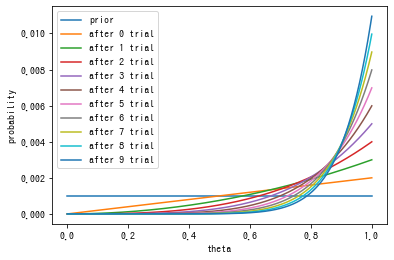

In [47]:
# 事前分布をuniform(x, 0,1)として、表を10回観測した場合
from scipy.stats import uniform

x = np.linspace(0, 1, 1000)
probability = pd.Series(uniform.pdf(x, 0, 1) * 0.001, index=x)
plt.plot(probability, label="prior")
for i in range(10): 
    # 更新
    probability = update_probability(1, 1, probability) # コインを1回なげたら、1回表がでた
    plt.plot(probability, label=f"after {i} trial") # 更新後のプロット

plt.ylabel("probability")
plt.xlabel("theta")
plt.legend()
map_theta = np.argmax(probability)
print("MAP推定値: ", map_theta)

##### 最尤推定

In [48]:
# 最小化したい関数。対数尤度を最大化したいので、-1 * 対数尤度を最小化する。
def neg_loglike_cointoss(params):
    likelihood = binom.pmf(10, 10, params)
    loglike = np.log(likelihood)
    return -loglike

result = minimize(neg_loglike_cointoss, [0.5], method='Nelder-Mead') # 初期値を0.5に
result.x

array([0.99998779])

結果は両者とも表の出る確率 = 1となり、一致する。(最尤推定の方は若干小さいが)

すなわち、最尤推定は、事前分布に自信が全くない場合のベイズ推定値、とも解釈できる。

### ベイズ推定の計算

さて、ベイズ推定によってパラメータの分布が推定できることが分かった。  
状態空間モデルも同様にして求めることができるのだが、ここで問題が発生する。  
状態空間モデルは求めたいパラメータの数が大変多い(シンプルなローカルレベルモデルであっても、tの数 + αのパラメータがある)。

上の例では、パラメータの数は「表の出る確率」1つだけだったので、確率を0から1まで1000に分けて、足し合わせて計算することができた。  
同じ方法をパラメータ数が10のモデルに使うと、足し合わせる分子の数は

In [49]:
1000 ** 10

1000000000000000000000000000000

となり、到底計算できる量ではない。  
また、状態空間モデルは簡単にパラメータ数が増えていくモデルである。ローカルレベルモデルでも、時系列の長さが100あれば、パラメータ数は100以上ある。

つまり、最尤推定のときと同様、ベイズ推定でも、パラメータが増えたときの計算がネックとなる。

最尤推定の場合は、調査するパラメータを一部に絞り、効率的に最良のパラメータを調査することで対策したが、ベイズ推定の場合の対策は2種類ある。

一つ目は各時点毎にパラメータを求める方法であり、これは粒子フィルタやカルマンフィルタに相当する。  
各時点毎に分けて考えれば、一回に推定するパラメータの数は少ないので、計算上もなんとかなるのである。  

二つ目は数値計算に効率的な手法を使用する方法であり、これはMCMCに相当する。  
MCMCは効率的に数値計算(正確には多重積分)を行う方法の一つで、これによって多くのパラメータがあっても、ゴリ押しでなんとか計算できるのである。

## 宿題

- スズキ様用の各パーツの月次ワランティ数について、SARIMAを用いて、tainingデータを使ってモデルを訓練し、validation期間について予測を行ってみてください。

- Aさんは夜に流れ星を見ていました。6時間夜空を眺めていたところ、各時間の流れ星の観測数は以下の通りでした。単位時間あたりの流れ星の平均発生数$\lambda$は一定だとして、最尤推定を用いて$\lambda$を推定して下さい。

In [50]:
n_metheor = [1, 3, 6, 2, 0, 2] # 個

- 上の問題について、ベイズ推定を用いて$\lambda$を推定して下さい。事前分布は自由に考えてみてください。(悩んだらTeamsで眞田までご連絡下さい)

- Bさんはある機械を使っていますが、この機械は割とすぐに壊れます。今まで使った機械について、使用開始から故障までの使用月数は以下の通りでした。平均使用可能期間$\beta$は一定だとして、最尤推定を用いてbetaを推定して下さい。

In [51]:
t_use = [1, 21,  6, 24,  2,  7,  2,  2,  4,  2,  1,  2,  0,  7,  4,  1,  1, 1,  6,  1]

- 上の問題について、ベイズ推定を用いて$\beta$を推定して下さい。事前分布は自由に考えてみてください。(悩んだらTeamsで眞田までご連絡下さい)

## 次回予告

### MCMC

### 粒子フィルタ

### カルマンフィルタ

#### (発展)カルマンフィルタ & 最尤推定

#### (発展)非線形カルマンフィルタ & 最尤推定